In [1]:
from sklearnex import patch_sklearn
patch_sklearn("LinearRegression")
import os
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
# from base import ensure_dir, make_predictions
from config import *
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from collections import defaultdict
from scipy.stats import ttest_1samp, spearmanr
import matplotlib.pyplot as plt
import gc
# from jax import jit, grad, vmap, device_put, random
# import jax.numpy as jnp
# from jax.lib import xla_bridge
# from functools import partial
import time
from base import ensure_dir, make_predictions


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# params
trial_types = ["all", "pattern", "random"]
trial_type = 'pattern'
data_path = DATA_DIR
lock = "stim"
subjects = SUBJS
sessions = ['practice', 'b1', 'b2', 'b3', 'b4']
subjects_dir = FREESURFER_DIR
res_path = RESULTS_DIR
folds = 10
chance = 0.5
threshold = 0.05
# scoring = "accuracy"
scoring = "roc_auc"
parc='aparc'
hemi = 'both'
params = "pred_decoding"
verbose = False
jobs = -1
decim = False

plt.style.use('dark_background')

# figures dir
figures = RESULTS_DIR / 'figures' / lock / params / 'source' / trial_type
ensure_dir(figures)
# get times
epoch_fname = DATA_DIR / lock / 'sub01_0_s-epo.fif'
epochs = mne.read_epochs(epoch_fname, verbose=verbose)
times = epochs.times
if decim:
    times = times[::3]
del epochs
gc.collect()

/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/open.py:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dirpos = int(tag.data)
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/tag.py:299: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  version=int(np.frombuffer(fid.read(4), dtype=">i4")),
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/tag.py:301: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s

0

In [3]:
subject = subjects[0]
# get labels
labels = mne.read_labels_from_annot(subject=subject, parc=parc, hemi=hemi, subjects_dir=subjects_dir, verbose=verbose)
# label = labels[ilabel]
        
session_id, session = 0, sessions[0]
# read stim epoch
epoch_fname = data_path / lock / f"{subject}_{session_id}_s-epo.fif"
epoch = mne.read_epochs(epoch_fname, preload=True, verbose=True)
# read behav
behav_fname = data_path / "behav" / f"{subject}_{session_id}.pkl"
behav = pd.read_pickle(behav_fname).reset_index()    
# get session behav and epoch
if session_id == 0:
    session = 'prac'
else:
    session = 'sess-%s' % (str(session_id).zfill(2))

if lock == 'button': 
    epoch_bsl_fname = data_path / "bsl" / f"{subject}_{session_id}_bl-epo.fif"
    epoch_bsl = mne.read_epochs(epoch_bsl_fname, verbose=verbose)
# read forward solution    
fwd_fname = res_path / "fwd" / lock / f"{subject}-fwd-{session_id}.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute data covariance matrix on evoked data
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
# compute noise covariance
if lock == 'button':
    noise_cov = mne.compute_covariance(epoch_bsl, method="empirical", rank="info", verbose=verbose)
else:
    noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
info = epoch.info
# conpute rank
rank = mne.compute_rank(noise_cov, info=info, rank=None, tol_kind='relative', verbose=verbose)
# compute source estimate
filters = make_lcmv(info, fwd, data_cov=data_cov, noise_cov=noise_cov,
                pick_ori=None, rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)

del epoch, fwd, data_cov, noise_cov, rank, filters
gc.collect()


Reading /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/preprocessed/stim/sub01_0_s-epo.fif ...
    Found the data of interest:
        t =    -196.61 ...     599.65 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/open.py:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dirpos = int(tag.data)
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/tag.py:299: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  version=int(np.frombuffer(fid.read(4), dtype=">i4")),
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/io/tag.py:301: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0

In [4]:
ilabel, label = 0, labels[0]
print(f"{ilabel+1}/{len(labels)}", subject, session, label.name)

# get stcs in label
stcs_data = [stc.in_label(label).data for stc in stcs]
stcs_data = np.array(stcs_data)
assert len(stcs_data) == len(behav)

if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = stcs_data[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = stcs_data[random]
    y = behav.positions[random]
else:
    X = stcs_data
    y = behav.positions
y = y.reset_index(drop=True).to_numpy()            
assert X.shape[0] == y.shape[0]

if decim:                 
    X = X[:, :, ::3]

print("X shape:", X.shape, "(trials, vertices, time points)")

1/68 sub01 prac bankssts-lh
X shape: (51, 47, 163) (trials, vertices, time points)


In [5]:
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegressionCV(multi_class="ovr", max_iter=100000, solver='saga', random_state=42)) # use JAX maybe
# clf = make_pipeline(StandardScaler(), SGDRegressor(loss="squared_error", max_iter=100000, random_state=42)) # use JAX maybe
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose) # get time of one sample (slide), try with less jobs maybe ?
cv = StratifiedKFold(folds, shuffle=True)

pred = np.zeros((len(y), X.shape[-1]))
pred_rock = np.zeros((len(y), X.shape[-1], len(set(y))))
# there is only randoms in practice sessions
for train, test in cv.split(X, y):
    clf.fit(X[train], y[train])
    pred[test] = np.array(clf.predict(X[test]))
    pred_rock[test] = np.array(clf.predict_proba(X[test]))


  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/datasets/eegbci/eegbci.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/datasets/eegbci/eegbci.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/datasets/eegbci/eegbci.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/mne/datasets/eegbci/eegbci.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/coum/opt/anaconda3/envs/fidle/lib

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coum/opt/anaconda3/envs/fidle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           1       0.18      0.15      0.17        13
           2       0.31      0.75      0.44        16
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11

    accuracy                           0.27        51
   macro avg       0.12      0.23      0.15        51
weighted avg       0.14      0.27      0.18        51



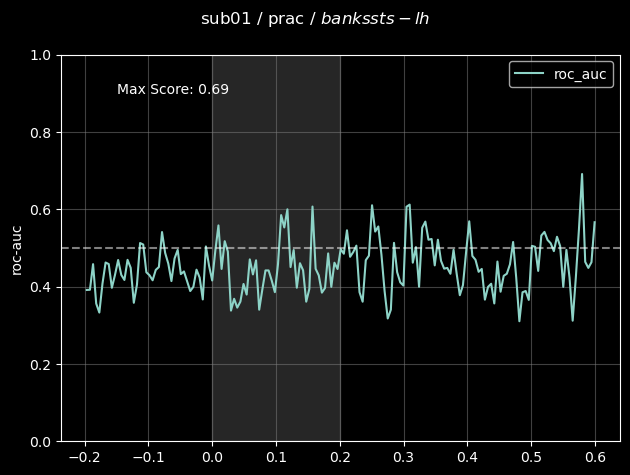

In [6]:
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
plt.style.use('dark_background')

cms, scores, acc, bacc = list(), list(), list(), list()
for t in range(X.shape[-1]):
    scores.append(roc_auc_score(y[:], pred_rock[:, t, :], multi_class='ovr'))
    cms.append(confusion_matrix(y[:], pred[:, t], normalize='true', labels=[1, 2, 3, 4]))
    acc.append(accuracy_score(y[:], pred[:, t]))
    bacc.append(balanced_accuracy_score(y[:], pred[:, t]))
results = classification_report(y[:], pred[:, 0])
print(results)

fig, ax1 = plt.subplots(1, 1, layout='tight')
fig.suptitle(f'{subject} / {session} / ${label.name}$')
ax1.plot(times, scores, label='roc_auc')
# ax1.plot(times, acc, label='acc')
# ax1.plot(times, bacc, label='bacc')

ax1.legend()

ax1.set_ylabel('roc-auc')
ax1.axvspan(0, 0.2, color='grey', alpha=.3)
ax1.axhline(chance, color='white', ls='dashed', alpha=.5)
max_score = max(scores)
ax1.annotate(f'Max Score: {max_score:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')                        
ax1.set_ylim(0, 1)
ax1.grid(True, color='grey', alpha=0.5)


In [15]:
from sklearn.linear_model import LogisticRegression
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegression(C=1, multi_class="ovr", max_iter=100000, solver='saga', random_state=42)) # use JAX maybe
# clf = make_pipeline(StandardScaler(), SGDRegressor(loss="squared_error", max_iter=100000, random_state=42)) # use JAX maybe
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose) # get time of one sample (slide), try with less jobs maybe ?
cv = StratifiedKFold(folds, shuffle=True)

pred = np.zeros((len(y), X.shape[-1]))
pred_rock = np.zeros((len(y), X.shape[-1], len(set(y))))
# there is only randoms in practice sessions
for train, test in cv.split(X, y):
    clf.fit(X[train], y[train])
    pred[test] = np.array(clf.predict(X[test]))
    pred_rock[test] = np.array(clf.predict_proba(X[test]))


  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/163 [00:00<?,       ?it/s]

              precision    recall  f1-score   support

           1       0.11      0.08      0.09        13
           2       0.24      0.31      0.27        16
           3       0.23      0.27      0.25        11
           4       0.12      0.09      0.11        11

    accuracy                           0.20        51
   macro avg       0.18      0.19      0.18        51
weighted avg       0.18      0.20      0.18        51



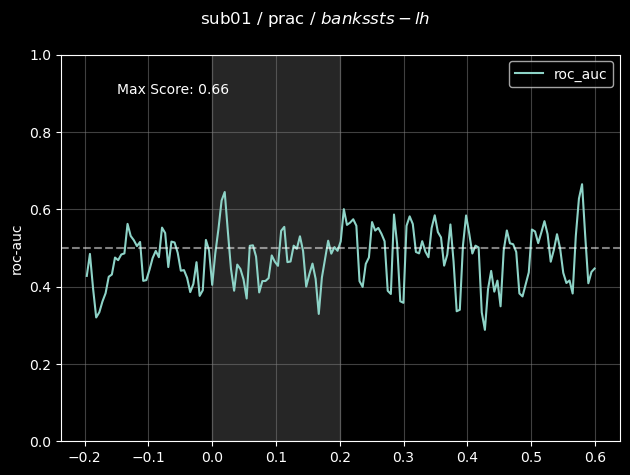

In [16]:
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
plt.style.use('dark_background')

cms, scores, acc, bacc = list(), list(), list(), list()
for t in range(X.shape[-1]):
    scores.append(roc_auc_score(y[:], pred_rock[:, t, :], multi_class='ovr'))
    cms.append(confusion_matrix(y[:], pred[:, t], normalize='true', labels=[1, 2, 3, 4]))
    acc.append(accuracy_score(y[:], pred[:, t]))
    bacc.append(balanced_accuracy_score(y[:], pred[:, t]))
results = classification_report(y[:], pred[:, 0])
print(results)

fig, ax1 = plt.subplots(1, 1, layout='tight')
fig.suptitle(f'{subject} / {session} / ${label.name}$')
ax1.plot(times, scores, label='roc_auc')
# ax1.plot(times, acc, label='acc')
# ax1.plot(times, bacc, label='bacc')

ax1.legend()

ax1.set_ylabel('roc-auc')
ax1.axvspan(0, 0.2, color='grey', alpha=.3)
ax1.axhline(chance, color='white', ls='dashed', alpha=.5)
max_score = max(scores)
ax1.annotate(f'Max Score: {max_score:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')                        
ax1.set_ylim(0, 1)
ax1.grid(True, color='grey', alpha=0.5)